In [15]:
import os

import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms
from tqdm.notebook import tqdm

from custom_image_dataset import CustomImageDataset

%matplotlib inline

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"We use: {device}")

We use: cuda


# I. Datasets and Dataloaders

#### Load dataset csv files as pd dataframes and print statistics

In [55]:
path_chest_imagenome_customized = "/u/home/tanida/datasets/chest-imagenome-dataset-customized-full"

# reduce memory usage by only using necessary columns and selecting appropriate datatypes
usecols = ["mimic_image_file_path", "bbox_name", "x1", "y1", "x2", "y2", "is_abnormal"]
dtype = {"x1": "int16", "x2": "int16", "y1": "int16", "y2": "int16", "bbox_name": "category"} 

datasets_as_dfs = {dataset: os.path.join(path_chest_imagenome_customized, dataset) + ".csv" for dataset in ["train", "valid", "test"]}
datasets_as_dfs = {dataset: pd.read_csv(csv_file_path, usecols=usecols, dtype=dtype) for dataset, csv_file_path in datasets_as_dfs.items()}

In [4]:
def print_num_samples_per_class(dataset, df):
    print(f"{dataset}:")
    for bbox_name, count in df["bbox_name"].value_counts().iteritems():
        print(f"\t{bbox_name}: {count}")
    print()

In [30]:
# get number of samples per class for each dataset

# bboxes of anatomical regions are almost distributed equally in all datasets,
# only a slight imbalance because not every image has bboxes of all 36 anatomical regions
for dataset, df in datasets_as_dfs.items():
    print_num_samples_per_class(dataset, df)

train:
	cardiac silhouette: 166490
	left lung: 166460
	mediastinum: 166456
	right lung: 166431
	spine: 166281
	trachea: 166280
	abdomen: 166276
	right upper abdomen: 166276
	left cardiac silhouette: 166272
	left upper abdomen: 166263
	upper mediastinum: 166260
	right upper lung zone: 166259
	right atrium: 166253
	left hemidiaphragm: 166237
	left upper lung zone: 166226
	right cardiac silhouette: 166214
	right hemidiaphragm: 166172
	right costophrenic angle: 166137
	cavoatrial junction: 166096
	right cardiophrenic angle: 166001
	left costophrenic angle: 165875
	svc: 165755
	left cardiophrenic angle: 165753
	descending aorta: 165705
	right clavicle: 165587
	left clavicle: 165442
	carina: 165188
	aortic arch: 164718
	right lower lung zone: 162983
	right mid lung zone: 162889
	right hilar structures: 162883
	right apical zone: 162836
	left lower lung zone: 162582
	left apical zone: 162386
	left hilar structures: 162170
	left mid lung zone: 162146

valid:
	cardiac silhouette: 23949
	right l

In [5]:
# get number of samples for each dataset
total_num_samples = sum(len(df) for df in datasets_as_dfs.values())

for dataset, df in datasets_as_dfs.items():
    print(f"{dataset}: {len(df):,} samples ({(len(df) / total_num_samples) * 100:.2f}%)")

train: 5,950,238 samples (70.00%)
valid: 855,467 samples (10.06%)
test: 1,694,389 samples (19.93%)


In [6]:
# if we don't want to train on the full train set (with 5,950,238 samples), we can specify the constant below to limit the train set

PERCENTAGE_OF_TRAIN_SET_TO_USE = 0.3
total_num_samples_train = len(datasets_as_dfs["train"])

new_num_samples_train = int(PERCENTAGE_OF_TRAIN_SET_TO_USE * total_num_samples_train)

datasets_as_dfs["train"] = datasets_as_dfs["train"][:new_num_samples_train]

print(f"train (new): {len(datasets_as_dfs['train']):,} samples")

train (new): 1,785,071 samples


#### Load datasets as Dataset objects

In [19]:
# constants for image transformations
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

IMAGE_INPUT_SIZE = 224  # pre-trained DenseNet121 model expects images to be of size 224x224

In [20]:
# note: transforms are applied to the already cropped images (see __getitem__ method of CustomImageDataset class)!

# use albumentations for Compose and transforms
train_transforms = A.Compose([
    # we want the long edge of the image to be resized to IMAGE_INPUT_SIZE, and the short edge of the image to be padded to IMAGE_INPUT_SIZE on both sides,
    # such that the aspect ratio of the images are kept (i.e. a resized image of a lung is not distorted), 
    # while getting images of uniform size (IMAGE_INPUT_SIZE x IMAGE_INPUT_SIZE)

    A.LongestMaxSize(max_size=IMAGE_INPUT_SIZE, interpolation=cv2.INTER_AREA),  # resizes the longer edge to IMAGE_INPUT_SIZE while maintaining the aspect ratio (INTER_AREA works best for shrinking images)
    A.PadIfNeeded(min_height=IMAGE_INPUT_SIZE, min_width=IMAGE_INPUT_SIZE, border_mode=cv2.BORDER_CONSTANT),  # pads both sides of the shorter edge with 0's (black pixels)
    A.Normalize(mean=mean, std=std),
    ToTensorV2()
])

# don't apply data augmentations to val and test set
val_test_transforms = A.Compose([
    A.LongestMaxSize(max_size=IMAGE_INPUT_SIZE, interpolation=cv2.INTER_AREA),
    A.PadIfNeeded(min_height=IMAGE_INPUT_SIZE, min_width=IMAGE_INPUT_SIZE, border_mode=cv2.BORDER_CONSTANT),
    A.Normalize(mean=mean, std=std),
    ToTensorV2()
])

In [ ]:
train_dataset = CustomImageDataset(dataset_df=datasets_as_dfs["train"], transforms=train_transforms)
val_dataset = CustomImageDataset(dataset_df=datasets_as_dfs["vald"], transforms=val_test_transforms)
test_dataset = CustomImageDataset(dataset_df=datasets_as_dfs["test"], transforms=val_test_transforms)

In [52]:
train_transforms = A.Compose([
    # we want the long edge of the image to be resized to IMAGE_INPUT_SIZE, and the short edge of the image to be padded to IMAGE_INPUT_SIZE on both sides,
    # such that the aspect ratio of the images are kept (i.e. a resized image of a lung is not distorted), 
    # while getting images of uniform size (IMAGE_INPUT_SIZE x IMAGE_INPUT_SIZE)

    # the custom class CustomResize resizes the longer edge to IMAGE_INPUT_SIZE while maintaining the aspect ratio
    A.LongestMaxSize(max_size=224, interpolation=cv2.INTER_AREA),
    A.PadIfNeeded(min_height=224, min_width=224, border_mode=cv2.BORDER_CONSTANT)
])

In [19]:
from PIL import Image
import cv2

(1242, 2019, 3)


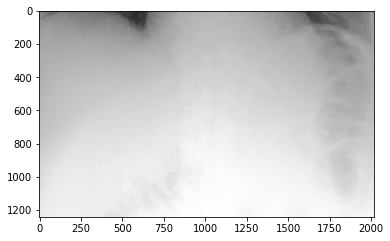

In [64]:
image_path = "/u/home/tanida/datasets/mimic-cxr-jpg/files/p10/p10001401/s50225296/0009a9fb-eb905e90-824cad7c-16d40468-007f0038.jpg"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
np_cropped_image = image[1800:3042, 245:2264]  # img[Y:Y+H, X:X+W]
print(np_cropped_image.shape)
plt.imshow(np_cropped_image)

<class 'PIL.Image.Image'>
(2019, 1242)


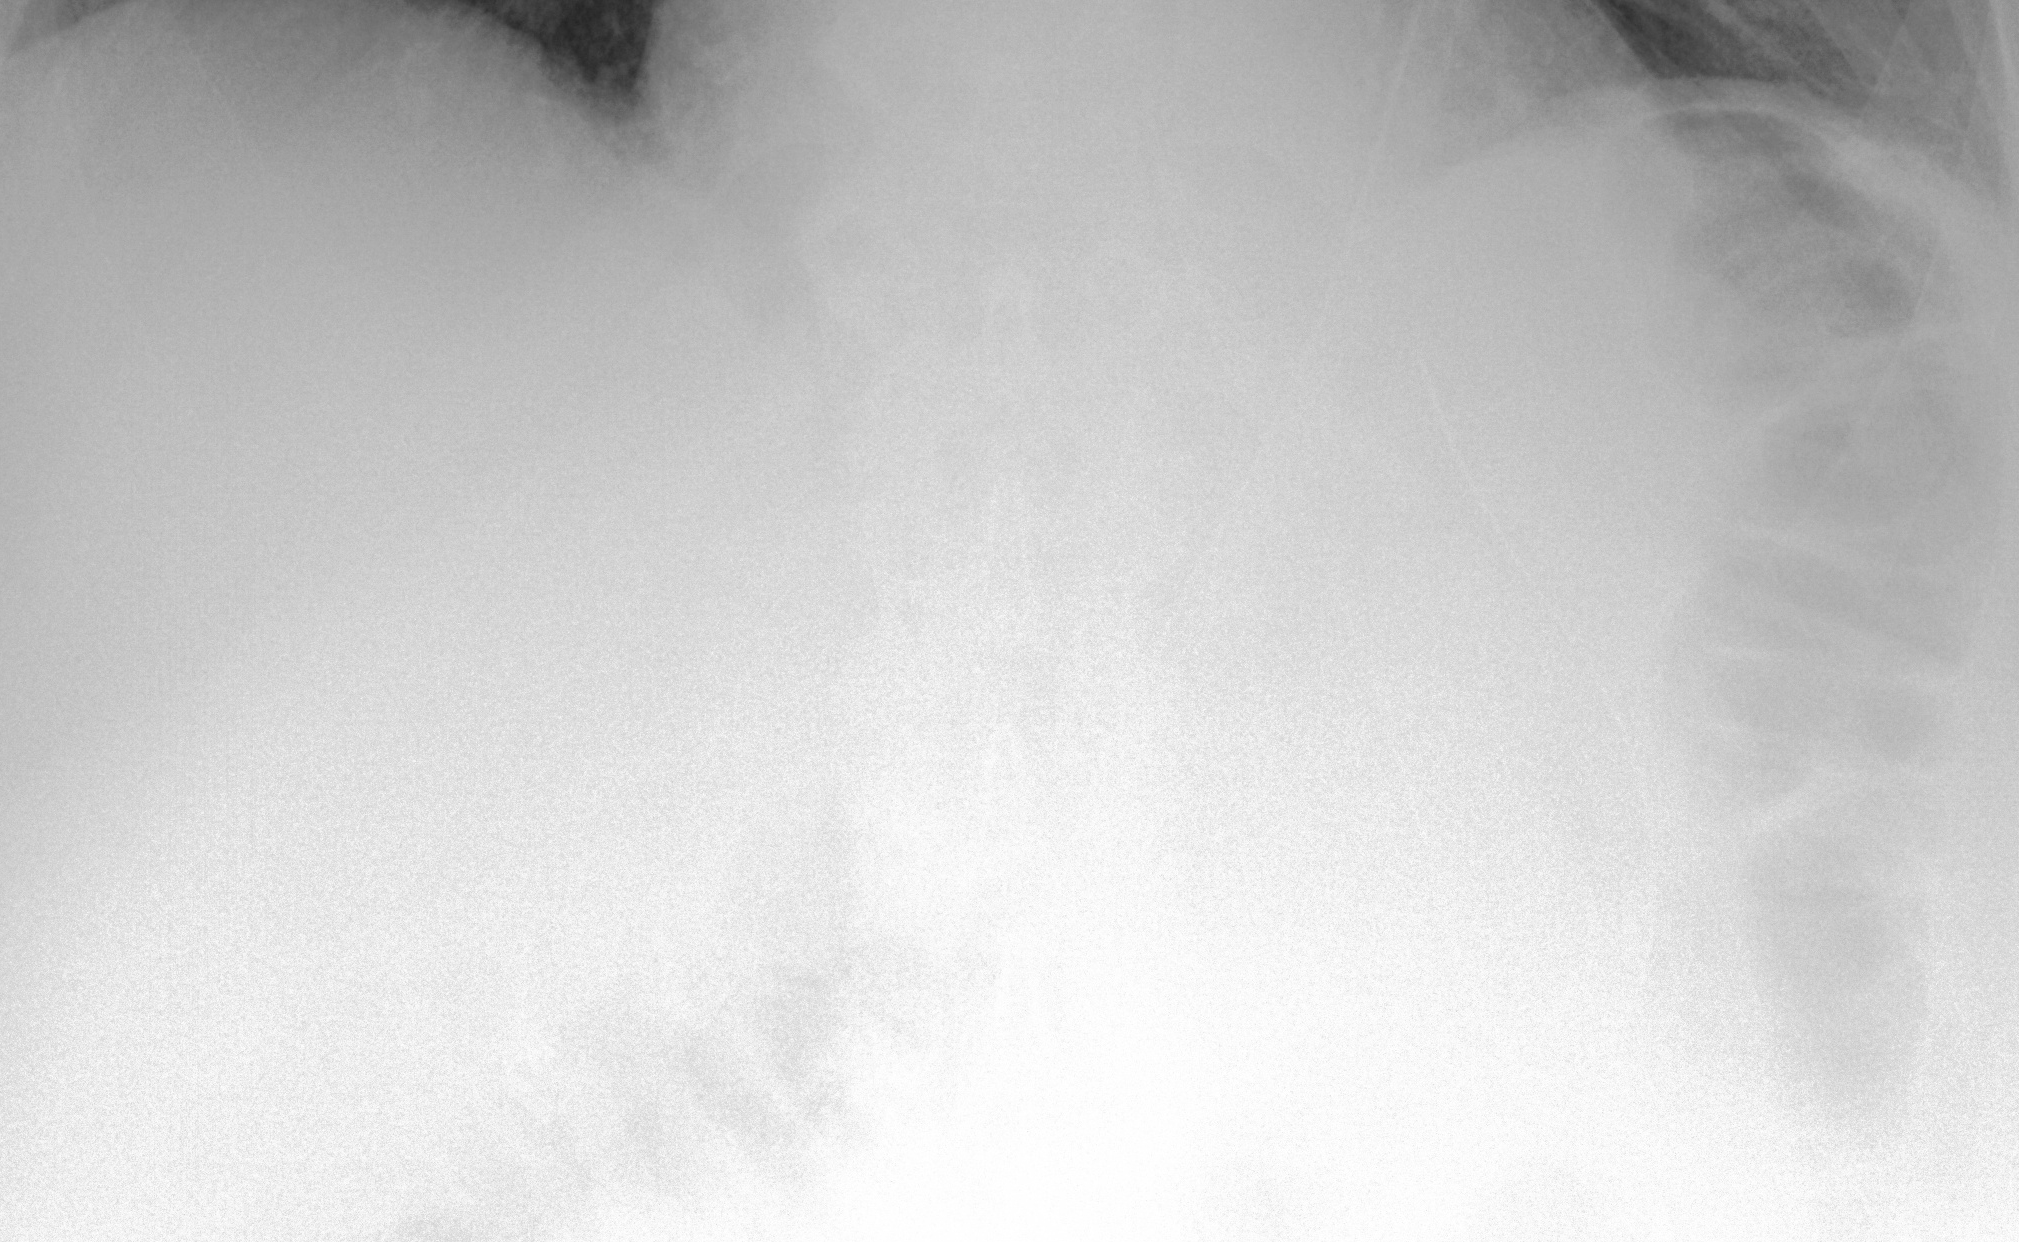

In [10]:
image_path = "/u/home/tanida/datasets/mimic-cxr-jpg/files/p10/p10001401/s50225296/0009a9fb-eb905e90-824cad7c-16d40468-007f0038.jpg"
image = Image.open(image_path)

bbox_coords = [245, 1800, 2264, 3042]
cropped_image = image.crop(box=bbox_coords)

print(type(cropped_image))
print(cropped_image.size)
display(cropped_image)

(224, 224, 3)


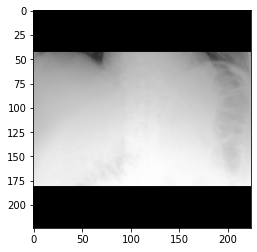

In [65]:
new_resized_cropped_image = train_transforms(image=np_cropped_image)["image"]
print(new_resized_cropped_image.shape)
plt.imshow(new_resized_cropped_image)

In [14]:
new_resized_cropped_image == resized_cropped_image

True

<PIL.Image.Image image mode=L size=224x137 at 0x7F7FEC73E950>


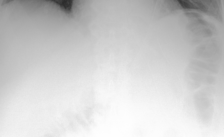

In [28]:
resized_cropped_image = transforms.functional.resize(cropped_image, size=223, max_size=224)
print(resized_cropped_image)
display(resized_cropped_image)

In [61]:
a, b, c, d = datasets_as_dfs["train"].head().iloc[2, 2:6]

In [62]:
a, b, c, d

(343, 550, 803, 848)

In [15]:
# specify path to folder where model weights should be saved
model_save_path = "/u/home/tanida/weights/encoder"